In [1]:
#env used: bbVV

from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import os

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})

In [2]:
MAIN_DIR = "../"

plot_dir = f"{MAIN_DIR}/plots/bias_test/30Jan24"
_ = os.system(f"mkdir -p {plot_dir}")

In [19]:
cards_dir = "23Sep22Scale100_bgs_only_scaleqcdsqrt"
bias_dir = "23Sep22"

# r_bounds = [-1, 20]
r_bounds = [-15, 15]

samples = [
    # "NMSSM_XToYHTo2W2BTo4Q2B_MX-1200_MY-190",
    "NMSSM_XToYHTo2W2BTo4Q2B_MX-2000_MY-125",
    # "NMSSM_XToYHTo2W2BTo4Q2B_MX-3000_MY-250",
]

# biases = [0.0, 0.15, 0.3, 1.0]
biases = ["0","1","0p3","0p6","3","5"]
biases = ["1"]
bias_dict = {
    # "0":0,
    "1":1,
    # "0p3":0.3,
    # "0p6":0.6,
    # "3":3,
    # "5":5
}
r_dict = {}


for bias in biases:
    file = uproot.concatenate(
        f"/home/pku/zhaoyz/Higgs/boostedHWW/combine/bias_test/cards/scale{bias}/higgsCombinebias{bias_dict[bias]}.FitDiagnostics.mH125.*.root"
    )
    r = np.array(file.limit)[::4]
    neg_lim = np.array(file.limit)[1::4]
    pos_lim = np.array(file.limit)[2::4]
    r_negerr = r - neg_lim #negetive error
    r_poserr = pos_lim - r #positive error
    reldiff = r - bias_dict[bias] #absolute difference for now
    reldiff[reldiff < 0] = (reldiff / r_poserr)[reldiff < 0] #change to absolute difference to relative difference
    reldiff[reldiff > 0] = (reldiff / r_negerr)[reldiff > 0] #by dividing error
    r_dict[bias] = {
        "r": r, #best fit signal strength
        "reldiff": reldiff, #relative difference
        "neg_lim": neg_lim,
        "pos_lim": pos_lim,
    }

In [20]:
# see the successful fits number
for i, bias in enumerate(biases):
    num_toys = len(r_dict[bias]["r"])
    print(
        f"For r = {bias}, # of successful fits: = {num_toys}, {np.sum(r_dict[bias]['neg_lim'] == r_bounds[0]) / num_toys * 100:.0f}% of these with r- = -5, {np.sum(r_dict[bias]['pos_lim'] == r_bounds[1]) / num_toys * 100 :.0f}% with r+ = 40"
    )

For r = 1, # of successful fits: = 50, 100% of these with r- = -5, 96% with r+ = 40


In [21]:
# see the fits with r-lim at boundary
for i, bias in enumerate(biases):
    num_toys = len(r_dict[bias]["r"])
    r_lims_bounds = (
        (r_dict[bias]["reldiff"] < 0) #means fitted r < injected r
        * (np.isclose(r_dict[bias]["pos_lim"], r_bounds[1]))
    ) + (
        (r_dict[bias]["reldiff"] > 0)
        * (np.isclose(r_dict[bias]["neg_lim"], r_bounds[0]))
    ) #bool array
    r_lims_wrong = r_dict[bias]["pos_lim"] == r_dict[bias]["neg_lim"] #fit results to positive limit == negetive limit, means fit failed
    tot_pfail = np.sum(r_lims_bounds + r_lims_wrong) #count how many events are failed/at boundary
    print(
        f"For r = {bias}, # of successful fits: = {num_toys}, {tot_pfail / num_toys * 100:.0f}% of these with r-lim at boundary"
    )

For r = 1, # of successful fits: = 50, 100% of these with r-lim at boundary


/home/pku/zhaoyz/anaconda3/envs/bbVV/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pku/zhaoyz/anaconda3/envs/bbVV/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pku/zhaoyz/anaconda3/envs/bbVV/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pku/zhaoyz/anaconda3/envs/bbVV/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pku/zhaoyz/anaconda3/envs/bbVV/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


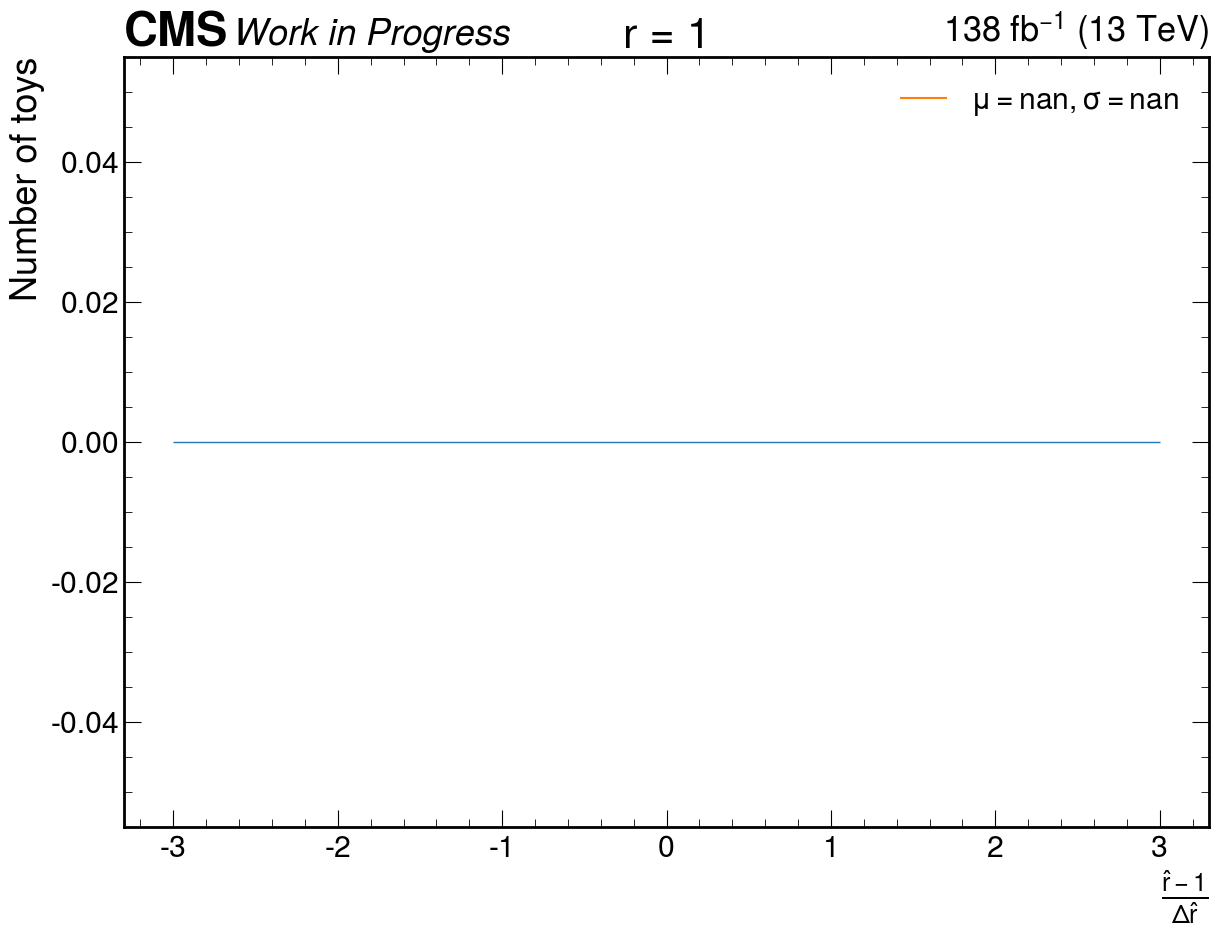

In [23]:
#plot the bias plots
from scipy import stats
xrange = 3
bins = 21
x = np.linspace(-xrange, xrange, 101)
hep.style.use("CMS")
plt.figure(figsize=(14, 10))
ax = plt.gca()
# fig, ax = plt.subplots(len(biases), 1, figsize=(12, 40))

for i, bias in enumerate(biases):
    # fit_fail = r_dict[sample][bias]["pos_lim"] == 40
    # fit_fail = r_dict[sample][bias]['pos_lim'] == 2000000
    r_lims_bounds = (
        (r_dict[bias]["reldiff"] < 0)
        * (np.isclose(r_dict[bias]["pos_lim"], r_bounds[1]))
    ) + (
        (r_dict[bias]["reldiff"] > 0)
        * (np.isclose(r_dict[bias]["neg_lim"], r_bounds[0]))
    )
    
    r_lims_same = r_dict[bias]["pos_lim"] == r_dict[bias]["neg_lim"]
    
    fit_fail = r_lims_bounds + r_lims_same #both cases results to failure of fit
    
    r = r_dict[bias]["r"][~fit_fail]
    reldiff = r_dict[bias]["reldiff"][~fit_fail]
    reldiff = reldiff[(reldiff > -xrange) * (reldiff < xrange)] #only select the relative difference within [-3,3]
    mu, sigma = np.mean(reldiff), np.std(reldiff)
    ax.hist(reldiff, np.linspace(-xrange, xrange, bins + 1), histtype="step")
    ax.plot(
        x,
        # scale by bin width
        stats.norm.pdf(x, loc=mu, scale=sigma) * len(r) * (2 * xrange / bins),
        label=rf"$\mu = {mu:.2f}, \sigma = {sigma:.2f}$",
    )
    ax.set_xlabel(rf"$\frac{{\hat{{r}} - {bias}}}{{\Delta \hat r}}$")
    ax.set_ylabel("Number of toys")
    ax.set_title(f"r = {bias}")
    ax.legend()
    hep.cms.label(
        "Work in Progress",
        ax=ax,
        data=True,
        lumi=138,
        year=None,
    )
    plt.savefig(f"{plot_dir}/bias_test_plots_{bias}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
sample = "NMSSM_XToYHTo2W2BTo4Q2B_MX-2000_MY-125"
bias = 0.0

r_lims_bounds = (
    (r_dict[sample][bias]["reldiff"] < 0)
    * (np.isclose(r_dict[sample][bias]["pos_lim"], r_bounds[1]))
) + (
    (r_dict[sample][bias]["reldiff"] > 0)
    * (np.isclose(r_dict[sample][bias]["neg_lim"], r_bounds[0]))
)

r_lims_same = r_dict[sample][bias]["pos_lim"] == r_dict[sample][bias]["neg_lim"]

fit_fail = r_lims_bounds + r_lims_same

preldiff = r_dict[sample][bias]["reldiff"][~fit_fail]
pposlim = r_dict[sample][bias]["pos_lim"][~fit_fail]
pneglim = r_dict[sample][bias]["neg_lim"][~fit_fail]
pr = r_dict[sample][bias]["r"][~fit_fail]

select = (preldiff >= -0.7) * (preldiff <= -0.6)

pos_lim = pposlim[select]
pos_lim

In [ ]:
pr[select]

In [ ]:
preldiff[select]

In [ ]:
plt.hist(r_dict[sample][bias]["pos_lim"])

In [ ]:
plt.hist(r_dict[sample][bias]["neg_lim"])

In [ ]:
r = pr[select]
r

In [ ]:
plt.hist(r_dict[sample][bias]["r"])

In [ ]:
neg_lim = pneglim[select]
neg_lim

In [ ]:
plt.hist(neg_lim)

In [ ]:
from ipywidgets import interact, FloatSlider


def phist(cut):
    plt.hist(pneglim[preldiff > cut], np.linspace(-0.5, 0.5, 21), histtype="step")


interact(phist, cut=FloatSlider(min=-1, max=5, step=0.1))

In [ ]:
reldiff = r_dict[sample][bias]["reldiff"][~fit_fail][select]
reldiff